In [1]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

In [13]:
N = 80
size = N+2
dt = 0.1
u_0 = 5
h = 1/N
d = 0.5 #diffusion speed
a= d*dt/h**2
rho_0 = 1
element_length = size / (size - 1)

x = np.linspace(0.0, size, size)
y = np.linspace(0.0,size, size)

    # Using "ij" indexing makes the differential operators more logical. Take
    # care when plotting.

X, Y = np.meshgrid(x, y, indexing="ij")

coordinates = np.concatenate(
        (X[..., np.newaxis],
            Y[..., np.newaxis]),axis=-1)

u = -y/np.sqrt(x**2 + y**2+0.01)* u_0
v = x/np.sqrt(x**2 + y**2+0.01)* u_0

u_field = np.ones((size, size, 2)) 
density = np.ones((size, size)) * rho_0
density[40,40] = 2
u_field[:,:,1] = u
u_field[:,:,0] = v
#density = np.zeros((size, size)) * rho_0


In [14]:
A = np.zeros((size**2, size**2))
B = np.zeros((size**2, size**2))
for i in range(size):
    for j in range(size):
        A[(i-1)*size+j, (i-1)*size+j] = 1+4*a
        A[(i-1)*size+j, (i-2)*size+j] = -a
        A[(i-1)*size+j, (i-1)*size+j-1] = -a
        A[(i-1)*size+j, (i-1)*size+j+1] = -a
        A[(i-1)*size+j, (i)*size+j] = -a

        
for i in range(size):
    for j in range(size):
        B[(i-1)*size+j, (i-1)*size+j] = 4
        B[(i-1)*size+j, (i-2)*size+j] = -1
        B[(i-1)*size+j, (i-1)*size+j-1] = -1
        B[(i-1)*size+j, (i-1)*size+j+1] = -1
        B[(i-1)*size+j, (i)*size+j] = -1

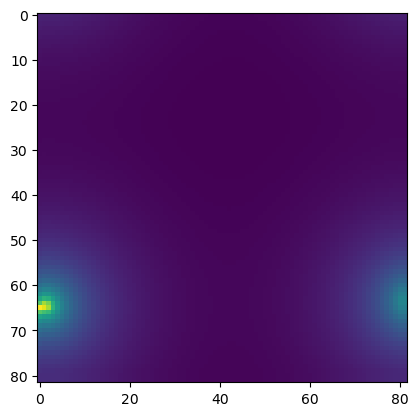

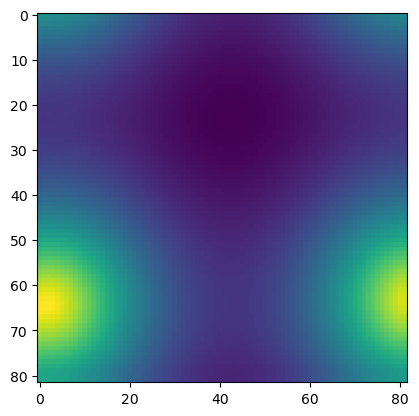

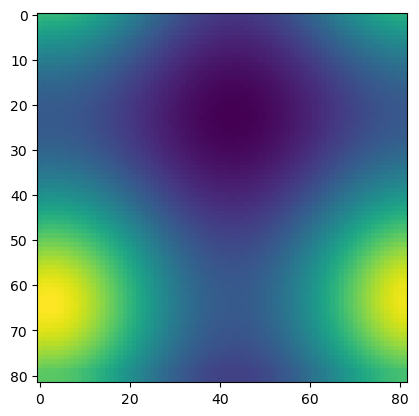

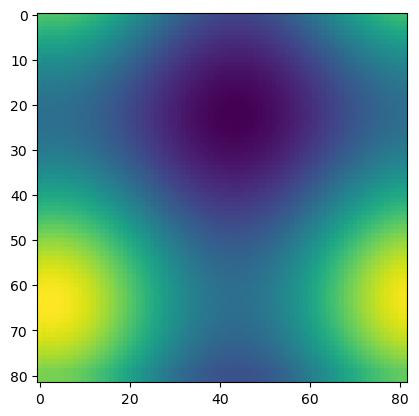

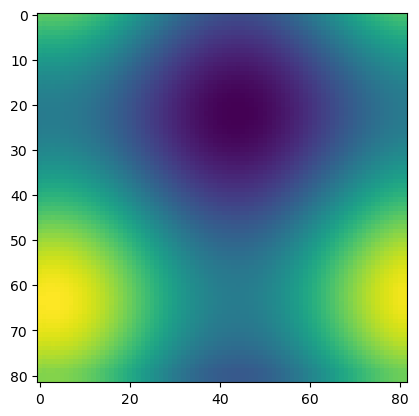

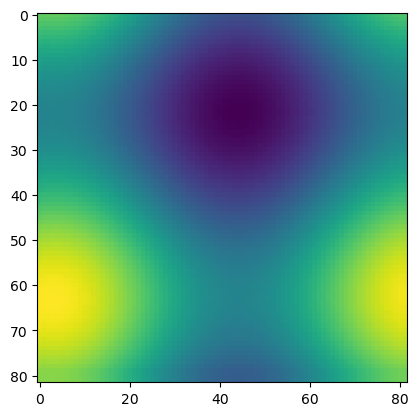

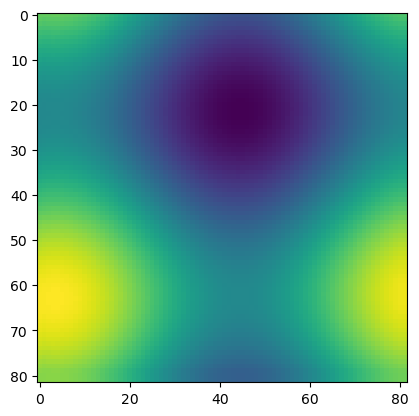

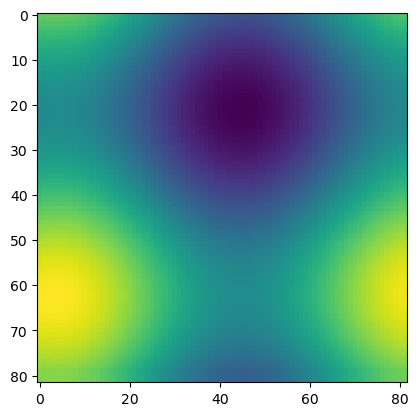

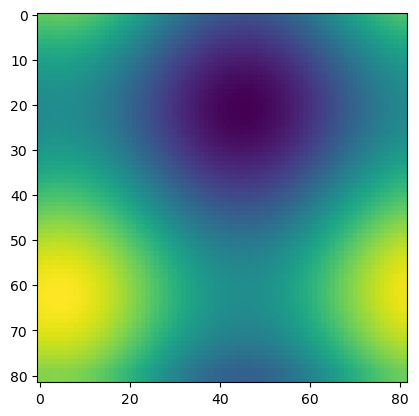

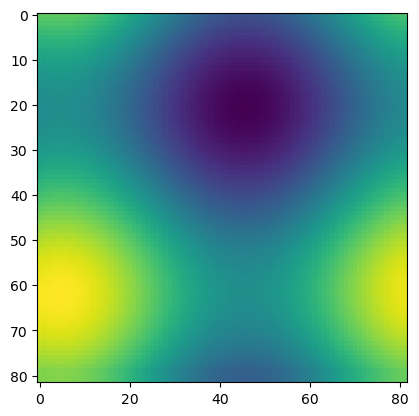

<Figure size 640x480 with 0 Axes>

In [15]:
def plotter():
    u = -y/np.sqrt(x**2 + y**2+0.01)* u_0
    v = x/np.sqrt(x**2 + y**2+0.01)* u_0
    u_field = np.ones((size, size, 2)) * u_0
    density = np.ones((size, size)) * rho_0
    density[65,1] = 5
    u_field[:,:,1] = v
    u_field[:,:,0] = u
    #print(density)
    plt.figure()
    for i in range(10):
        density=np.linalg.solve(A, density.flatten()).reshape((size, size))
        density=advect(density, u_field)
        plt.imshow(density)
        plt.draw()
        plt.pause(0.01)
        plt.clf()
plotter()

In [6]:
def advect(field, vector_field):
    backtraced_positions = np.clip((coordinates-dt*vector_field),0.5, N + 0.5)    
    interp = RegularGridInterpolator((x, y), field)
    advected_field = interp(backtraced_positions)

    return advected_field

In [6]:
def f(x, y):
    return 2 * x**3 + 3 * y**2 
x = np.linspace(1, 4, 4)
y = np.linspace(1, 4, 4)

xg, yg  = np.meshgrid(x, y, indexing='ij', sparse=True)
data = f(xg, yg)
print(data)
data.shape

[[  5.  14.  29.  50.]
 [ 19.  28.  43.  64.]
 [ 57.  66.  81. 102.]
 [131. 140. 155. 176.]]


(4, 4)

In [7]:
interp = RegularGridInterpolator((x, y), data)
pts = np.array([[2.1, 1.2],
                [3.3, 2.2]])
interp(pts)

array([24.6, 91.2])

In [17]:
def partial_derivative_x(field):
    diff = np.zeros_like(field)
    diff[1:-1, 1:-1] = (field[2:  , 1:-1]-field[0:-2, 1:-1]) / (2 * element_length)
    return diff

def partial_derivative_y(field):
    diff = np.zeros_like(field)
    diff[1:-1, 1:-1] = (field[1:-1, 2:  ]-field[1:-1, 0:-2]) / (2 * element_length)
    return diff

def laplace(field):
    diff = np.zeros_like(field)

    diff[1:-1, 1:-1] = ((
                field[0:-2, 1:-1]
                +
                field[1:-1, 0:-2]
                - 4 *
                field[1:-1, 1:-1]
                +
                field[2:  , 1:-1]
                +
                field[1:-1, 2:  ]
            )/element_length**2)
        
    return diff
    
def divergence(vector_field):
    divergence_applied = (partial_derivative_x(vector_field[..., 0])
        +
        partial_derivative_y(vector_field[..., 1]))
    return divergence_applied
    
def gradient(field):
    gradient_applied = np.concatenate((
                partial_derivative_x(field)[..., np.newaxis],
                partial_derivative_y(field)[..., np.newaxis]),axis=-1)
    return gradient_applied

In [9]:
velocities_projected = (u_field - gradient(density))

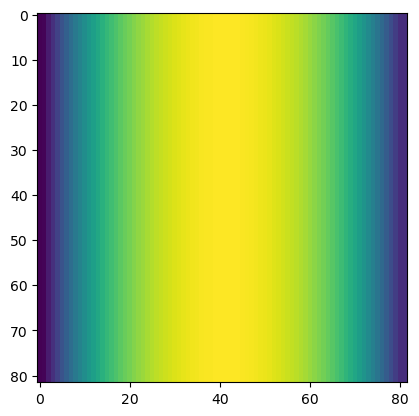

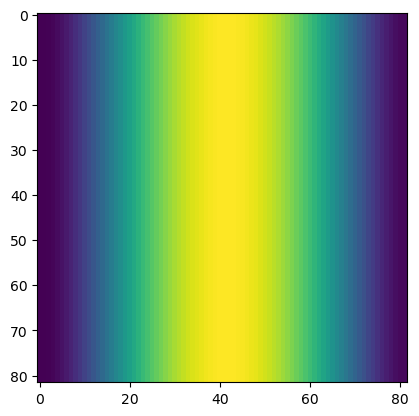

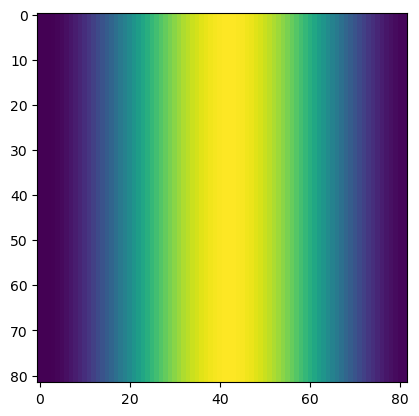

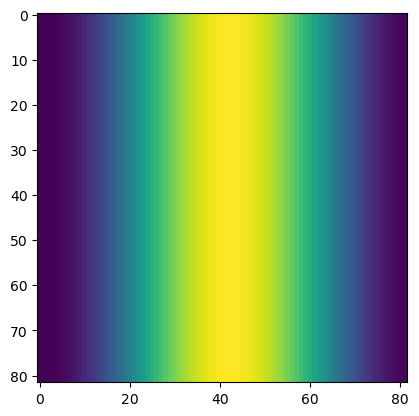

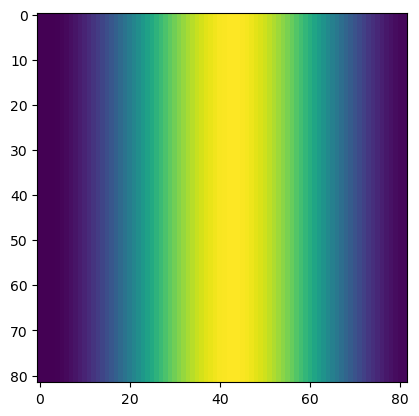

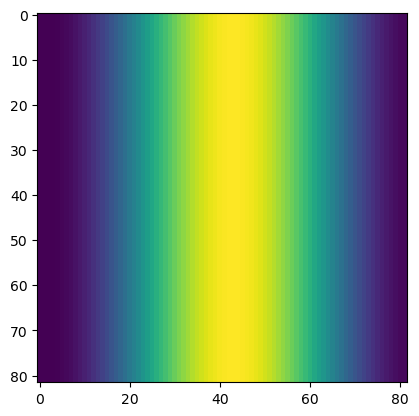

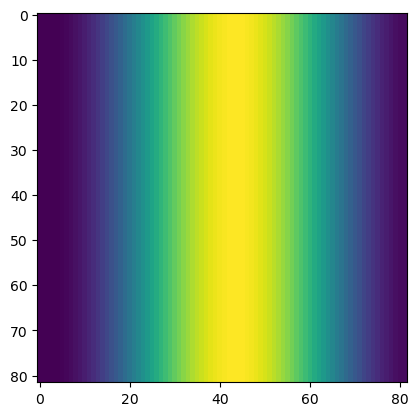

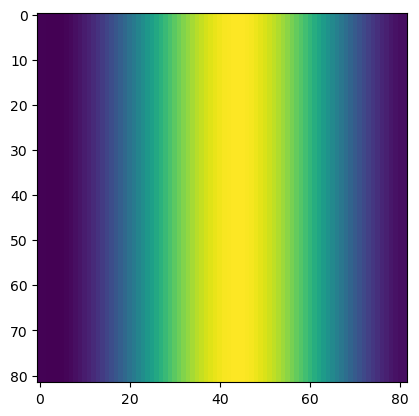

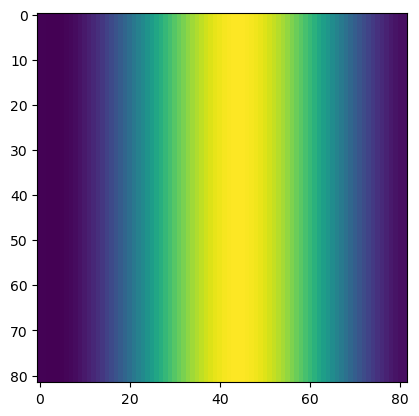

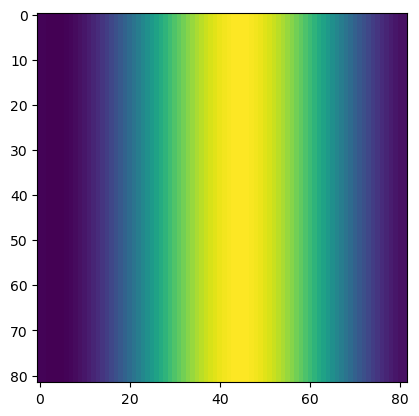

<Figure size 640x480 with 0 Axes>

In [20]:
u = -y/np.sqrt(x**2 + y**2+0.01)* u_0
v = x/np.sqrt(x**2 + y**2+0.01)* u_0
u_field = np.ones((size, size, 2)) * u_0
density = np.ones((size, size)) * rho_0
density[65,1] = 5
u_field[:,:,1] = v
u_field[:,:,0] = u
plt.figure()
for i in range(10):
    u_field=np.linalg.solve(A, u_field.reshape( size**2, 2)).reshape((size, size, 2))

    u_field=advect(u_field, u_field)
    #u_field -= gradient(density)
    
    plt.imshow(np.sqrt(u_field[:,:,0]**2+ u_field[:,:,1]**2))
    plt.draw()
    plt.pause(0.01)
    plt.clf()

In [17]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

cylinder = np.full((size, size), False)
for y in range(0, size):
    for x in range(0, size):
        if distance(13,13, x, y)<13: 
            cylinder[y][x] =True
density[cylinder] = 0.0
density

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def project(N, u):
    """project."""
    h = 1.0 / N
    div= (-0.5 * h *
                             (u[:,:, 0] - u[:,:, 0]+
                              u[:,:, 1] - u[:,:, 1]))
    #p[1:N + 1, 1:N + 1] = 0
    #set_bnd(N, 0, div)
    #set_bnd(N, 0, p)
    p = np.linalg.solve(B, div.flatten).reshape((size, size,  2))
                                                             
    u[1:N + 1, 1:N + 1, 0] -= 0.5 * (p[2:N + 2, 1:N + 1,:] - p[0:N, 1:N + 1,:]) / h
    u[1:N + 1, 1:N + 1, 1] -= 0.5 * (p[1:N + 1, 2:N + 2,:] - p[1:N + 1, 0:N,:]) / h
    
    """
    div[1:N + 1, 1:N + 1,:] = (-0.5 * h *
                             (u[2:N + 2, 1:N + 1, 0] - u[0:N, 1:N + 1, 0] +
                              u[1:N + 1, 2:N + 2, 1] - u[1:N + 1, 0:N, 1]))
    p[1:N + 1, 1:N + 1] = 0
    #set_bnd(N, 0, div)
    #set_bnd(N, 0, p)
    p = np.linalg.solve(B, div.reshape( size**2, 2)).reshape(size, size, 2)
                                                             
    u[1:N + 1, 1:N + 1, 0] -= 0.5 * (p[2:N + 2, 1:N + 1,:] - p[0:N, 1:N + 1,:]) / h
    u[1:N + 1, 1:N + 1, 1] -= 0.5 * (p[1:N + 1, 2:N + 2,:] - p[1:N + 1, 0:N,:]) / h
    #set_bnd(N, 1, u)
    #set_bnd(N, 2, v)
    """
    
    return u

In [ ]:
project(size, u_field)

In [ ]:
def set_bnd(N, b, x):
    """We assume that the fluid is contained in a box with solid walls.
    No flow should exit the walls. This simply means that the horizontal
    component of the velocity should be zero on the vertical walls, while the
    vertical component of the velocity should be zero on the horizontal walls.
    For the density and other fields considered in the code we simply assume
    continuity. The following code implements these conditions.
    """

    for i in range(1, N + 1):
        if b == 1:
            x[0, i] = -x[1, i]
        else:
            x[0, i] = x[1, i]
        if b == 1:
            x[N + 1, i] = -x[N, i]
        else:
            x[N + 1, i] = x[N, i]
        if b == 2:
            x[i, 0] = -x[i, 1]
        else:
            x[i, 0] = x[i, 1]
        if b == 2:
            x[i, N + 1] = -x[i, N]
        else:
            x[i, N + 1] = x[i, N]

    x[0, 0] = 0.5 * (x[1, 0] + x[0, 1])
    x[0, N + 1] = 0.5 * (x[1, N + 1] + x[0, N])
    x[N + 1, 0] = 0.5 * (x[N, 0] + x[N + 1, 1])
    x[N + 1, N + 1] = 0.5 * (x[N, N + 1] + x[N + 1, N])

In [ ]:
def lin_solve(N, b, x, x0, a, c):
    """lin_solve."""

    for k in range(0, 20):
        x[1:N + 1, 1:N + 1] = (x0[1:N + 1, 1:N + 1] + a *
                               (x[0:N, 1:N + 1] +
                                x[2:N + 2, 1:N + 1] +
                                x[1:N + 1, 0:N] +
                                x[1:N + 1, 2:N + 2])) / c
        set_bnd(N, b, x)

In [ ]:
def add_source(N, x, s, dt):
    """Addition of forces: the density increases due to sources."""
    x[0:size, 0:size] += dt * s[0:size, 0:size]

In [ ]:
def diffuse(N, b, x, x0, diff, dt):
    """Diffusion: the density diffuses at a certain rate.
    The basic idea behind our method is to find the densities which when
    diffused backward in time yield the densities we started with. The simplest
    iterative solver which works well in practice is Gauss-Seidel relaxation.
    """

    a = dt * diff * N * N
    lin_solve(N, b, x, x0, a, 1 + 4 * a)

In [ ]:
def advect_(N, b, d, d0, u, v, dt):
    """Advection: the density follows the velocity field.
    The basic idea behind the advection step. Instead of moving the cell
    centers forward in time through the velocity field, we look for the
    particles which end up exactly at the cell centers by tracing backwards in
    time from the cell centers.
    """

    dt0 = dt * N
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            x = i - dt0 * u[i, j]
            y = j - dt0 * v[i, j]
            if x < 0.5:
                x = 0.5
            if x > N + 0.5:
                x = N + 0.5
            i0 = int(x)
            i1 = i0 + 1
            if y < 0.5:
                y = 0.5
            if y > N + 0.5:
                y = N + 0.5
            j0 = int(y)
            j1 = j0 + 1
            s1 = x - i0
            s0 = 1 - s1
            t1 = y - j0
            t0 = 1 - t1
            d[i, j] = (s0 * (t0 * d0[i0, j0] + t1 * d0[i0, j1]) + s1 *
                       (t0 * d0[i1, j0] + t1 * d0[i1, j1]))
    set_bnd(N, b, d)


In [ ]:
def project(N, u, v, p, div):
    """project."""

    h = 1.0 / N
    div[1:N + 1, 1:N + 1] = (-0.5 * h *
                             (u[2:N + 2, 1:N + 1] - u[0:N, 1:N + 1] +
                              v[1:N + 1, 2:N + 2] - v[1:N + 1, 0:N]))
    p[1:N + 1, 1:N + 1] = 0
    set_bnd(N, 0, div)
    set_bnd(N, 0, p)
    lin_solve(N, 0, p, div, 1, 4)
    u[1:N + 1, 1:N + 1] -= 0.5 * (p[2:N + 2, 1:N + 1] - p[0:N, 1:N + 1]) / h
    v[1:N + 1, 1:N + 1] -= 0.5 * (p[1:N + 1, 2:N + 2] - p[1:N + 1, 0:N]) / h
    set_bnd(N, 1, u)
    set_bnd(N, 2, v)

In [ ]:
def dens_step(N, x, x0, u, v, diff, dt):
    """Evolving density.
    It implies advection, diffusion, addition of sources.
    """

    add_source(N, x, x0, dt)
    x0, x = x, x0  # swap
    diffuse(N, 0, x, x0, diff, dt)
    x0, x = x, x0  # swap
    advect(N, 0, x, x0, u, v, dt)


def vel_step(N, u, v, u0, v0, visc, dt):
    """Evolving velocity.
    It implies self-advection, viscous diffusion, addition of forces.
    """

    add_source(N, u, u0, dt)
    add_source(N, v, v0, dt)
    u0, u = u, u0  # swap
    diffuse(N, 1, u, u0, visc, dt)
    v0, v = v, v0  # swap
    diffuse(N, 2, v, v0, visc, dt)
    project(N, u, v, u0, v0)
    u0, u = u, u0  # swap
    v0, v = v, v0  # swap
    advect(N, 1, u, u0, u0, v0, dt)
    advect(N, 2, v, v0, u0, v0, dt)
    project(N, u, v, u0, v0)

In [ ]:
dens_step(N, x, density, u, v, diff, dt)